In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_excel('数据/GDP、GDP增长率、美债.xlsx')
# 定义转换函数
def quarter_to_date(quarter_str):
    year, quarter = quarter_str.split('年')
    quarter_dict = {"第一季度": "03-31", "第二季度": "06-30", "第三季度": "09-30", "第四季度": "12-31"}
    return pd.to_datetime(f"{year}-{quarter_dict[quarter]}")
columns = df.columns
new_columns = [quarter_to_date(col) for col in columns]
df.columns = new_columns
df = df.T
df.columns = ['GDP增长率', 'GDP', '美债']
print(df.head())

            GDP增长率           GDP            美债
1993-06-30     2.3  6.729459e+12  4.270540e+12
1993-09-30     1.9  6.808939e+12  4.367061e+12
1993-12-31     5.6  6.882098e+12  4.450080e+12
1994-03-31     3.9  7.013738e+12  4.533452e+12
1994-06-30     5.5  7.115652e+12  4.583661e+12


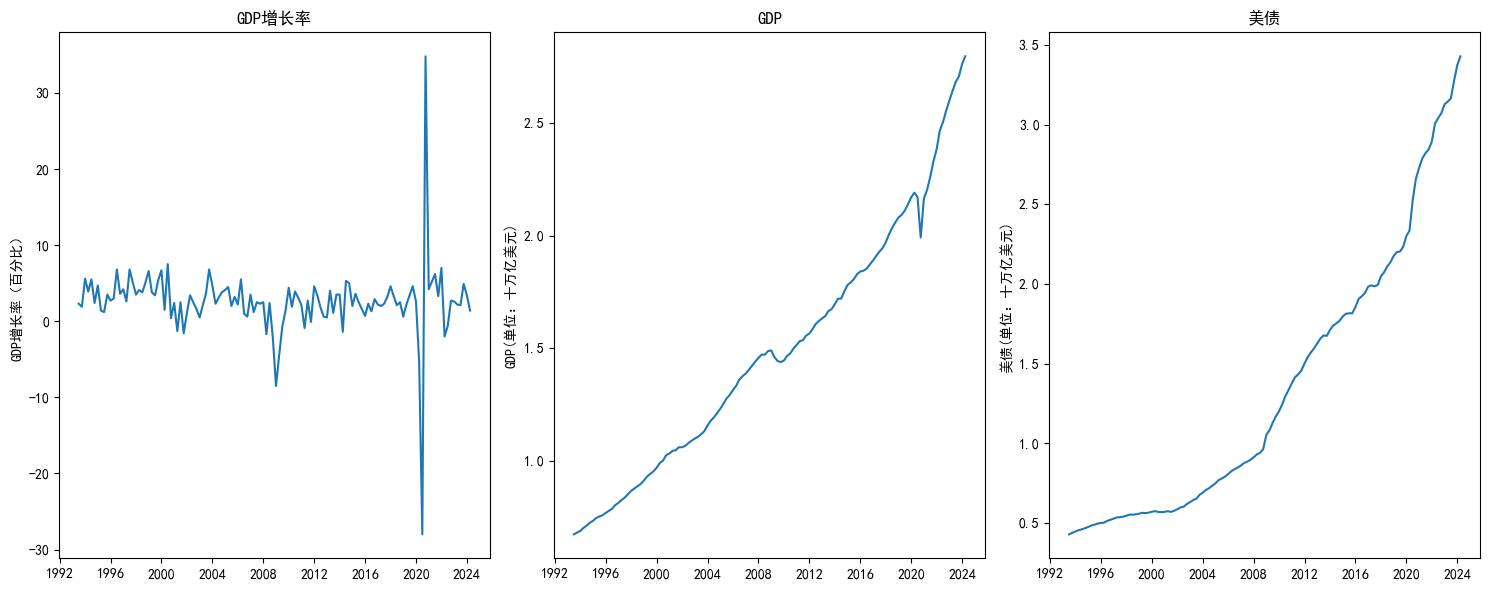

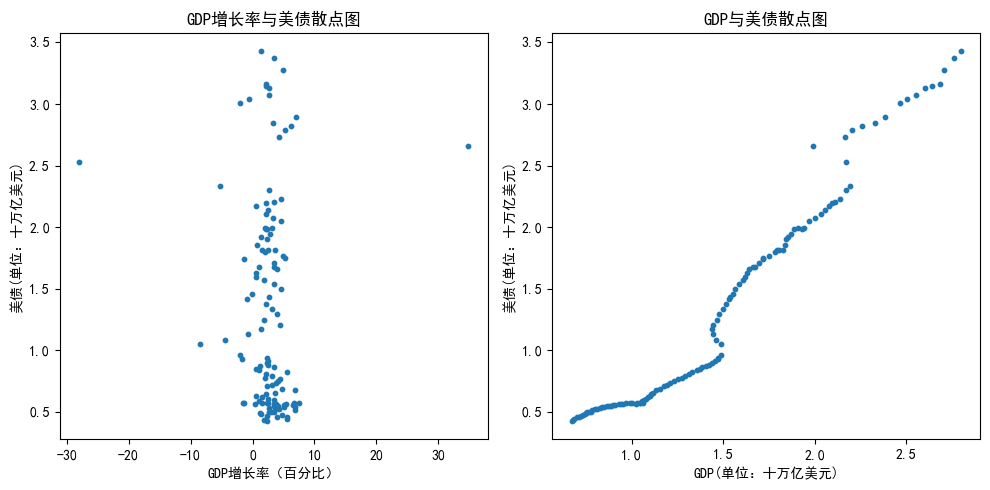

In [122]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
plots = ['GDP增长率', 'GDP', '美债']
axs[0].plot(df.index, df['GDP增长率'])
axs[0].set_ylabel('GDP增长率（百分比）')
axs[1].plot(df.index, df['GDP']/1e13)
axs[1].set_ylabel('GDP(单位：十万亿美元)')
axs[2].plot(df.index, df['美债']/1e13)
axs[2].set_ylabel('美债(单位：十万亿美元)')
for i, plot in enumerate(plots):
    axs[i].set_title(plot)
    # axs[i].legend()
plt.tight_layout()
plt.savefig('结果2-1/GDP、GDP增长率、美债时间序列图.png')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plots = ['GDP增长率', 'GDP']
axs[0].scatter(df['GDP增长率'], df['美债']/1e13, label=plot, s=10)
axs[1].scatter(df['GDP']/1e13, df['美债']/1e13, label=plot, s=10)
axs[0].set_xlabel('GDP增长率（百分比）')
axs[1].set_xlabel('GDP(单位：十万亿美元)')
for i, plot in enumerate(plots):
    axs[i].set_title(f'{plot}与美债散点图')
    axs[i].set_ylabel('美债(单位：十万亿美元)')
    # axs[i].legend(loc='upper left')
plt.tight_layout()
plt.savefig('结果2-1/GDP、GDP增长率与美债散点图.png')
plt.show()


In [73]:
# 分割数据集
df_1 = df[df.index <= '2008-09-30']
df_2 = df[(df.index >= '2009-03-31') & (df.index <= '2019-12-31')]
df_3 = df[df.index >= '2020-12-31']
dfs = [df_1, df_2, df_3]

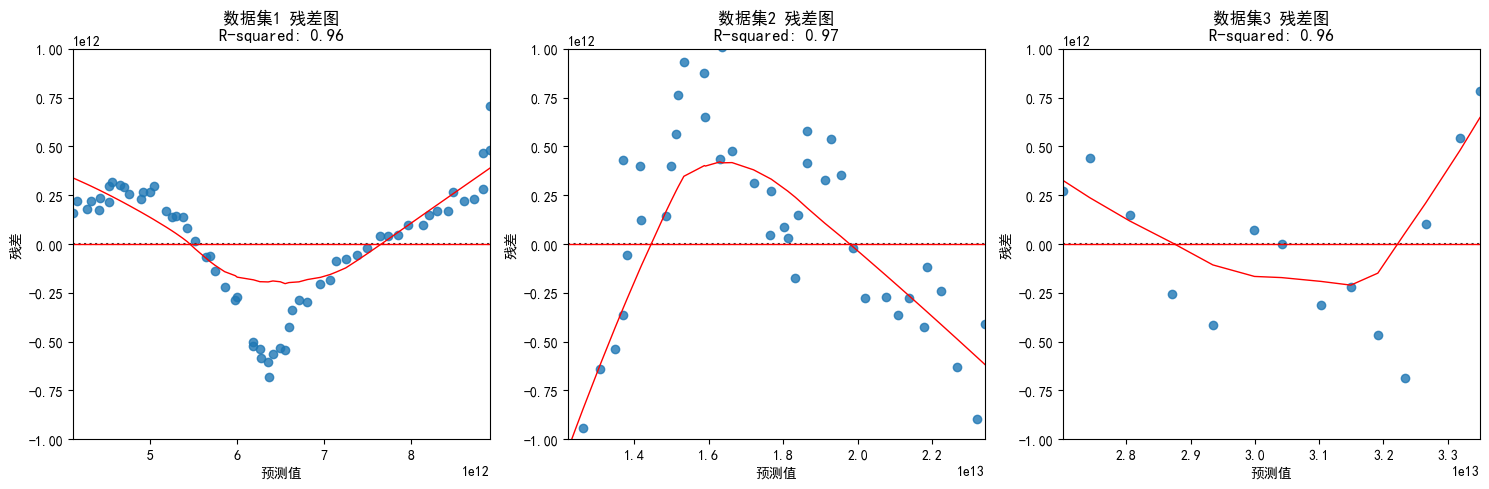

In [129]:
# 设置绘图大小
plt.figure(figsize=(15, 5))
for i, dfi in enumerate(dfs, 1):
    # 定义自变量和因变量
    X = dfi[['GDP', 'GDP增长率']]
    y = dfi['美债']    
    # 添加常数项到自变量中
    X = sm.add_constant(X)
    # 构建线性回归模型
    model = sm.OLS(y, X).fit()
    # 获取模型的预测值
    predictions = model.predict(X)
    # 计算残差
    residuals = y - predictions
    # 绘制残差图
    plt.subplot(1, 3, i)
    sns.residplot(x=predictions, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.ylim(-1e12, 1e12)
    plt.title(f'数据集{i} 残差图\nR-squared: {model.rsquared:.2f}')
    plt.xlabel('预测值')
    plt.ylabel('残差')
    plt.axhline(0, color='red', linewidth=1)

plt.tight_layout()
plt.savefig('结果2-1/线性回归残差图.png')
plt.show()

In [121]:
# 梯度下降法更新系数
def gradient_descent(X, y, theta, learning_rate=0.001):
    iterations=10000 * (100//y.shape[0])
    m = len(y)
    cost_history = np.zeros(iterations)
    for it in range(iterations):
        prediction = np.dot(X, theta)
        theta = theta - (1/m) * learning_rate * (X.T.dot((prediction - y)))
        cost_history[it] = (1/(2*m)) * np.sum(np.square(prediction - y))
    return theta, cost_history

# 在应用梯度下降之前对特征进行缩放

scaler = StandardScaler()


r_squared_values = np.zeros((4, 4, 3))

for i, dfi in enumerate(dfs):
    X = dfi[['GDP', 'GDP增长率']]
    y = dfi['美债'].values
    
    # 应用特征缩放
    X_scaled = scaler.fit_transform(X)
    
    for degree_gdp in range(1, 5):
        for degree_growth in range(1, 5):
            # 为GDP和GDP增长率添加指定次数的多项式特征
            poly_gdp = PolynomialFeatures(degree=degree_gdp, include_bias=False)
            poly_growth = PolynomialFeatures(degree=degree_growth, include_bias=False)
            
            X_gdp_poly = poly_gdp.fit_transform(X_scaled[:, 0].reshape(-1, 1))
            X_growth_poly = poly_growth.fit_transform(X_scaled[:, 1].reshape(-1, 1))
            
            # 合并多项式特征
            X_poly = np.concatenate((X_gdp_poly, X_growth_poly), axis=1)
            
            # 添加常数项
            X_poly = sm.add_constant(X_poly)
            
            # 初始化系数
            theta = np.random.randn(X_poly.shape[1], 1)
            
            # 使用梯度下降法求解系数
            theta, _ = gradient_descent(X_poly, y.reshape(-1,1), theta)
            
            # 使用求解的系数计算R方值
            prediction = X_poly.dot(theta)
            ss_res = np.sum(np.square(prediction - y.reshape(-1,1)))
            ss_tot = np.sum(np.square(y - np.mean(y)))
            r_squared = 1 - (ss_res / ss_tot)
            
            # 存储R方值
            r_squared_values[degree_gdp-1, degree_growth-1, i] = r_squared


with pd.ExcelWriter('数据/R方矩阵.xlsx') as writer:
    for i in range(3):
        df_r_squared = pd.DataFrame(r_squared_values[:, :, i], 
                                    index=[f'GDP {degree}次项' for degree in range(1, 5)], 
                                    columns=[f'GDP增长率 {degree}次项' for degree in range(1, 5)])
        
        print(f"数据集 {i+1} 的R方矩阵:")
        print(df_r_squared)
        print("\n")
        

        df_r_squared.to_excel(writer, sheet_name=f'数据集{i+1}')
r_squared_values_np = np.array(r_squared_values)
np.save('数据/r_squared_values.npy', r_squared_values_np)

数据集 1 的R方矩阵:
         GDP增长率 1次项  GDP增长率 2次项  GDP增长率 3次项  GDP增长率 4次项
GDP 1次项    0.955024    0.955121    0.955833    0.928189
GDP 2次项    0.981617    0.975135    0.968071    0.933476
GDP 3次项    0.980447    0.976643    0.969038    0.932007
GDP 4次项    0.977945    0.972095    0.970309    0.939682


数据集 2 的R方矩阵:
         GDP增长率 1次项  GDP增长率 2次项  GDP增长率 3次项  GDP增长率 4次项
GDP 1次项    0.969074    0.973448    0.975544    0.974844
GDP 2次项    0.987399    0.989611    0.990283    0.990285
GDP 3次项    0.993765    0.995921    0.994626    0.994241
GDP 4次项    0.970713    0.970674    0.966546    0.967207


数据集 3 的R方矩阵:
         GDP增长率 1次项  GDP增长率 2次项  GDP增长率 3次项  GDP增长率 4次项
GDP 1次项    0.963121    0.963132    0.967306    0.974075
GDP 2次项    0.984524    0.988305    0.988702    0.990243
GDP 3次项    0.988848    0.990001    0.990893    0.993063
GDP 4次项    0.969609    0.957549    0.929876    0.929337




数据集 1 的函数表达式:
美债预测值 = 5.880+ 1.366*g + 0.404*g^2 + 0.115*ggr 

数据集 2 的函数表达式:
美债预测值 = 17.921+ 2.727*g - 0.584*g^2 + 0.287*g^3 + 0.075*ggr - 0.088*ggr^2 

数据集 3 的函数表达式:
美债预测值 = 29.971+ 1.995*g + 0.423*g^2 + 0.143*g^3 + 0.238*ggr + 0.334*ggr^2 - 0.134*ggr^3 - 0.089*ggr^4 



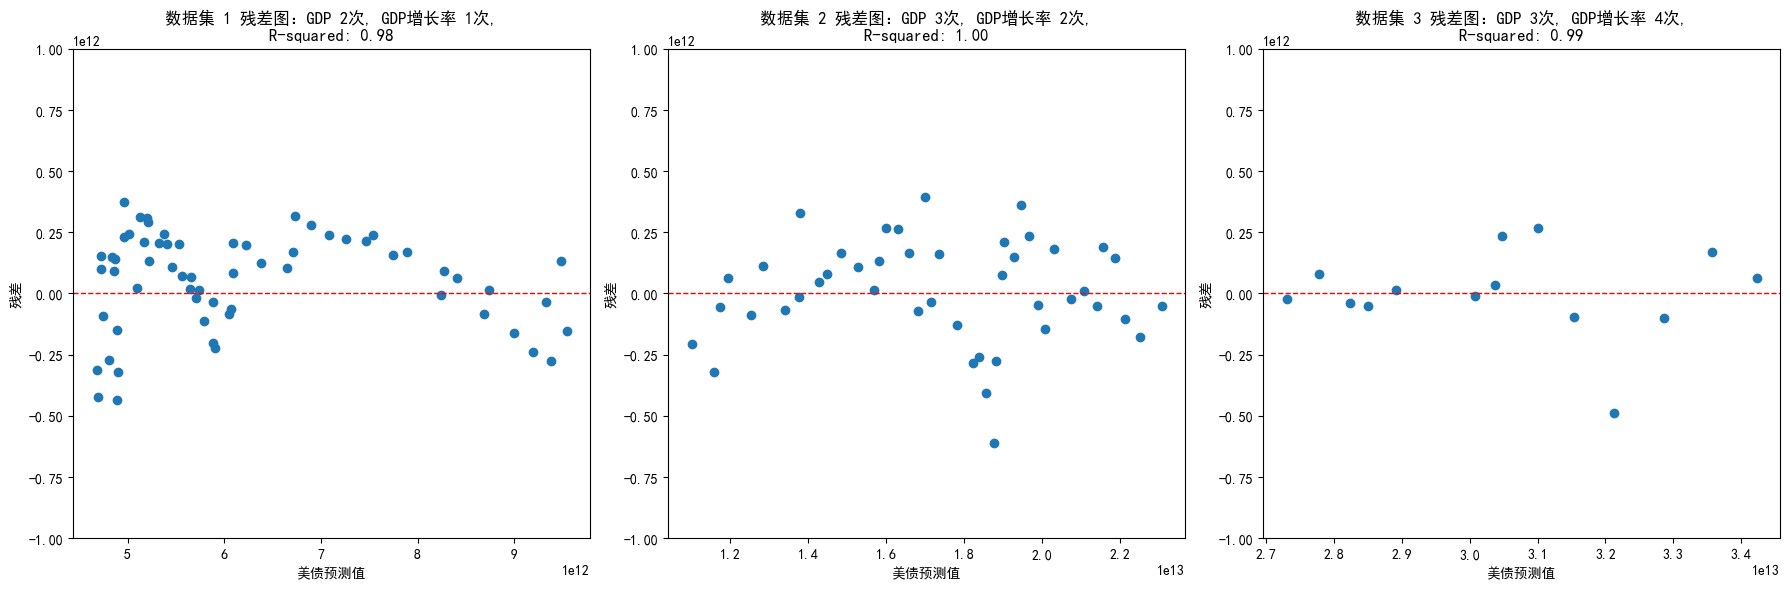

In [124]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, dfi in enumerate(dfs):
    X = dfi[['GDP', 'GDP增长率']]
    y = dfi['美债'].values
    X_scaled = scaler.fit_transform(X) # 输入的是标准化后的值
    
    # 找到R方值最大的组合
    max_r_squared_index = np.unravel_index(np.argmax(r_squared_values[:, :, i]), r_squared_values[:, :, i].shape)
    degree_gdp_best, degree_growth_best = max_r_squared_index
    
    # 重新构建模型
    poly_gdp_best = PolynomialFeatures(degree=degree_gdp_best+1, include_bias=False)
    poly_growth_best = PolynomialFeatures(degree=degree_growth_best+1, include_bias=False)
    X_gdp_poly_best = poly_gdp_best.fit_transform(X_scaled[:, 0].reshape(-1, 1))
    X_growth_poly_best = poly_growth_best.fit_transform(X_scaled[:, 1].reshape(-1, 1))
    
    X_poly_best = np.concatenate((X_gdp_poly_best, X_growth_poly_best), axis=1)
    X_poly_best = sm.add_constant(X_poly_best)  # 添加常数项
    # 初始化系数
    theta_best = np.random.randn(X_poly_best.shape[1], 1)
    
    # 使用梯度下降法求解系数
    theta_best, _ = gradient_descent(X_poly_best, y.reshape(-1,1), theta_best)
    
    # 使用求解的系数计算预测值
    predictions = X_poly_best.dot(theta_best)
    
    # 计算残差
    residuals = y.reshape(-1,1) - predictions
   
    # 绘制残差图
    axs[i].scatter(predictions, residuals)
    axs[i].set_title(f'数据集 {i+1} 残差图：GDP {degree_gdp_best + 1}次, GDP增长率 {degree_growth_best + 1}次,\nR-squared: {r_squared_values[degree_gdp_best, degree_growth_best, i]:.2f}')
    axs[i].set_xlabel('美债预测值')
    axs[i].set_ylabel('残差')
    axs[i].axhline(y=0, color='red', linewidth=1, linestyle='--')
    axs[i].set_ylim(-1e12, 1e12)

    # 为了生成函数表达式，我们需要特征的名称
    feature_names_gdp = poly_gdp_best.get_feature_names_out(['g'])
    feature_names_growth = poly_growth_best.get_feature_names_out(['ggr'])
    feature_names = np.concatenate((feature_names_gdp, feature_names_growth))

    # 构建函数表达式
    expression = f"美债预测值 = {theta_best.flatten()[0]/1e12:.3f}"
    for coef, name in zip(theta_best.flatten()[1:]/1e12, feature_names):
        if coef >= 0:
            expression += f"+ {coef:.3f}*{name} "
        else:
            expression += f"- {-coef:.3f}*{name} "
    print(f"数据集 {i+1} 的函数表达式:\n{expression}\n")
    
plt.tight_layout()
plt.savefig('结果2-1/最佳的多项式回归残差图.png')
plt.show()

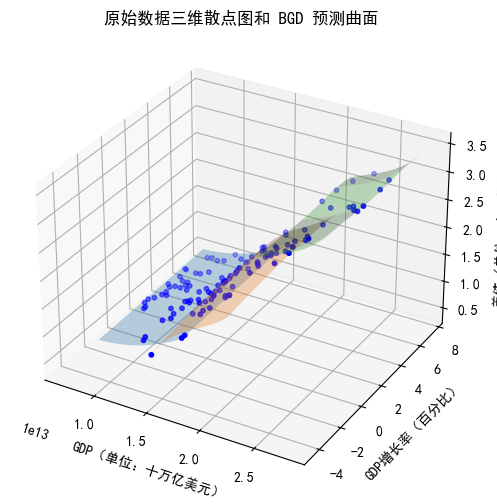

In [125]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111, projection='3d')

for i, dfi in enumerate(dfs):
    X = dfi[['GDP', 'GDP增长率']]
    y = dfi['美债'].values
    X_scaled = scaler.fit_transform(X)  # 输入的是标准化后的值

    # 找到R方值最大的组合
    max_r_squared_index = np.unravel_index(np.argmax(r_squared_values[:, :, i]), r_squared_values[:, :, i].shape)
    degree_gdp_best, degree_growth_best = max_r_squared_index

    # 重新构建模型
    poly_gdp_best = PolynomialFeatures(degree=degree_gdp_best+1, include_bias=False)
    poly_growth_best = PolynomialFeatures(degree=degree_growth_best+1, include_bias=False)
    X_gdp_poly_best = poly_gdp_best.fit_transform(X_scaled[:, 0].reshape(-1, 1))
    X_growth_poly_best = poly_growth_best.fit_transform(X_scaled[:, 1].reshape(-1, 1))

    X_poly_best = np.concatenate((X_gdp_poly_best, X_growth_poly_best), axis=1)
    X_poly_best = sm.add_constant(X_poly_best)  # 添加常数项
    # 初始化系数
    theta_best = np.random.randn(X_poly_best.shape[1], 1)

    # 使用梯度下降法求解系数
    theta_best, _ = gradient_descent(X_poly_best, y.reshape(-1,1), theta_best)

    # 创建网格数据
    gdp_range = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 20)
    growth_range = np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 20)
    gdp_grid, growth_grid = np.meshgrid(gdp_range, growth_range)

    # 计算网格上每一点的预测值
    X_grid_poly_gdp = poly_gdp_best.transform(gdp_grid.reshape(-1, 1))
    X_grid_poly_growth = poly_growth_best.transform(growth_grid.reshape(-1, 1))
    X_grid_poly = np.concatenate((X_grid_poly_gdp, X_grid_poly_growth), axis=1)
    X_grid_poly = sm.add_constant(X_grid_poly)  # 添加常数项
    predictions_grid = X_grid_poly.dot(theta_best)

    # 将gdp_grid和growth_grid转换回原始尺度
    gdp_growth_grid_scaled = np.vstack((gdp_grid.flatten(), growth_grid.flatten())).T
    gdp_growth_grid_original = scaler.inverse_transform(gdp_growth_grid_scaled)
    gdp_grid_original, growth_grid_original = gdp_growth_grid_original[:, 0].reshape(gdp_grid.shape), gdp_growth_grid_original[:, 1].reshape(growth_grid.shape)

    # 绘制预测曲面
    ax.plot_surface(gdp_grid_original, growth_grid_original, predictions_grid.reshape(gdp_grid.shape), alpha=0.3)

    # 绘制原始数据的三维散点图
    X_original = scaler.inverse_transform(X_scaled)
    ax.scatter(X_original[:, 0], X_original[:, 1], y, color='blue', s=10)

ax.set_xlabel('GDP（单位：十万亿美元）')
ax.set_ylabel('GDP增长率（百分比）')
ax.set_zlabel('美债（单位：十万亿美元）')
ax.set_title('原始数据三维散点图和 BGD 预测曲面')
plt.savefig('结果2-1/原始数据三维散点图和 BGD 预测曲面.png')
plt.show()